# Model Training - Python Models

ML.NET is being used as the primary model training platform for this project, but this notebook serves to evaluate some alternatives in SciKit-Learn

In [2]:
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import scikitplot as skplt

import pandas as pd
import numpy as np

## Define Common Methods

## Data Loading

In [3]:
df = pd.read_csv('./data/Training.csv')
df.head()

,PredictedLabel,ActualLabel,Message,Reasoning,Sha,Source,ParentSha,Parent2Sha,IsMerge,AuthorId,...,HasDeletedFiles,DayOfWeek,Month,Quarter,Year,Hour,TimeOfDay,IsWeekend,MessageLength,WordCount
0,False,False,Add test,Adding a test does not fix a bug but rather he...,e1283c0b37e7e664e0323116baaba9592d346e87,dotnetinteractive,7e81c00180c4ddb02b5339337eec5f78ed9c4342,NaN,False,20,...,False,Tuesday,March,1,2020,19,Evening,False,8,2
1,False,False,Merge pull request #2836 from AbhitejJohn/fixtypo,The commit message does not explicitly mention...,b611a4a5401468b7734d2b009e23889bae3818d3,dotnetinteractive,d8b80c3010319df99c115b8b0eaf622e9ced603d,340acfc3d824d5a6c4238cc20e6caf4552a67b1c,True,87,...,False,Tuesday,March,1,2023,18,Afternoon,False,49,6
2,False,False,notebook changes,The term 'changes' is too vague and doesn't sp...,d5a26683e4f1d2ab4d6de82941efee5bb427ebd3,dotnetinteractive,85d038234705fe1936a380b61ee2aaad66930a03,NaN,False,10,...,False,Thursday,February,1,2021,19,Evening,False,16,2
3,False,False,Merge pull request #553 from cartermp/fsharp-s...,Pull request reference does not indicate a bug...,a51e8526d30521cbdc29c484ffd080fb0c9656b2,dotnetinteractive,342b0de01d4dfcfc97f0f71bf4e711bdd0be6edc,aa0e789b01c6fb683804eca8e041a378cf075694,True,10,...,True,Friday,October,4,2019,5,Night,False,59,6
4,False,False,Update dependencies from https://github.com/do...,The description suggests updating software com...,2f30b1841bb7a6555196b94c4c7d829c1ad362e1,dotnetinteractive,d3e65742fe6ae8b4646476465b7532d99a6e041f,NaN,False,23,...,False,Monday,December,4,2020,8,Morning,False,74,6


In [4]:
# Remove unnecessary columns
df = df.drop(columns=["PredictedLabel", "Reasoning", "AuthorId", "AuthorDateUtc", "CommitterId", "CommitterDateUtc", "ParentSha", "Parent2Sha", "DayOfWeek", "Month", "Quarter", "Year", "Hour", "TimeOfDay", "IsWeekend", "Sha", "Source"])

# Rename the ActualLabel column to Label
df = df.rename(columns={"ActualLabel": "Label"})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Label            499 non-null    bool  
 1   Message          499 non-null    object
 2   IsMerge          499 non-null    bool  
 3   WorkItems        499 non-null    int64 
 4   TotalFiles       499 non-null    int64 
 5   ModifiedFiles    499 non-null    int64 
 6   AddedFiles       499 non-null    int64 
 7   DeletedFiles     499 non-null    int64 
 8   TotalLines       499 non-null    int64 
 9   NetLines         499 non-null    int64 
 10  AddedLines       499 non-null    int64 
 11  DeletedLines     499 non-null    int64 
 12  HasAddedFiles    499 non-null    bool  
 13  HasDeletedFiles  499 non-null    bool  
 14  MessageLength    499 non-null    int64 
 15  WordCount        499 non-null    int64 
dtypes: bool(4), int64(11), object(1)
memory usage: 48.9+ KB


### Text Processing

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/matteland/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Stem and remove stop words from df["Message"]
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def normalize_stem_and_remove_stopwords(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = [ps.stem(word) for word in text.split() if word not in stop_words]
    return ' '.join(text)

df["Message"] = df["Message"].apply(normalize_stem_and_remove_stopwords)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_text = df['Message']

vectorizer = TfidfVectorizer(ngram_range=(1, 3))  # Adjust n-gram range
X_ngrams = vectorizer.fit_transform(X_text)

X_ngrams.shape

(499, 3918)

In [8]:
# Creeate a DataFrame from the n-grams with string names
df_nGrams = pd.DataFrame(X_ngrams.toarray(), columns=vectorizer.get_feature_names_out())
df_nGrams.head()

,0006,0006 1182,015,015 preview,015 preview 3956,05,06,06 782,06 bag,06 bag bash,...,xml document fastforest,xml document poisson,xml document transform,xref,xref format,xref format 4647,xunitcombinatori,xunitcombinatori test,xunitcombinatori test project,yaml
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df = pd.concat([df, df_nGrams], axis=1)
df = df.drop(columns=["Message"])
df.head()

,Label,IsMerge,WorkItems,TotalFiles,ModifiedFiles,AddedFiles,DeletedFiles,TotalLines,NetLines,AddedLines,...,xml document fastforest,xml document poisson,xml document transform,xref,xref format,xref format 4647,xunitcombinatori,xunitcombinatori test,xunitcombinatori test project,yaml
0,False,False,0,1,1,0,0,964,18,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,False,True,1,2,2,0,0,188,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,False,False,0,1,1,0,0,538,60,535,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,False,True,1,3,1,1,1,1198,203,492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,False,False,0,4,4,0,0,567,5,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
X = df.drop(columns=["Label"])
y = df["Label"]

In [11]:
# Split the data into training and testing sets. We'll use the test one as a final validation layer and do cross-validation on the rest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Model Training

### Logistic Regression

In [12]:
# Build a dictionary of common binary classifiers

classifiers = {
    "RandomForest": RandomForestClassifier(max_depth=20, random_state=42),
    "SVC": SVC(probability=True, kernel='linear', class_weight='balanced', random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=5000, random_state=42),
    "MultinomialNB": MultinomialNB(),
    "KNeighbors": KNeighborsClassifier(n_neighbors=5),
    "MLP": MLPClassifier(random_state=42, max_iter=5000, hidden_layer_sizes=(50, 50), activation='relu', alpha=0.0001)
}

-----------------------------
RandomForest
-----------------------------
F1: 0.11655913978494623
Accuracy: 0.7274343434343434
Positive Precision: 1.0
Positive Recall: 0.06206896551724138
Negative Precision: 0.7224489795918367
Negative Recall: 1.0
-----------------------------
SVC
-----------------------------
F1: 0.5151479405651421
Accuracy: 0.8035757575757575
Positive Precision: 0.8983050847457628
Positive Recall: 0.36551724137931035
Negative Precision: 0.7909090909090909
Negative Recall: 0.9830508474576272
-----------------------------
LogisticRegression
-----------------------------
F1: 0.21262463343108506
Accuracy: 0.7434343434343434
Positive Precision: 0.9047619047619048
Positive Recall: 0.1310344827586207
Negative Precision: 0.7364016736401674
Negative Recall: 0.9943502824858758
-----------------------------
MultinomialNB
-----------------------------
F1: 0.42165934931892374
Accuracy: 0.7434949494949494
Positive Precision: 0.6024096385542169
Positive Recall: 0.3448275862068966
Ne

/home/matteland/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matteland/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1: 0.05247311827956989
Accuracy: 0.7174141414141414
Positive Precision: 1.0
Positive Recall: 0.027586206896551724
Negative Precision: 0.7151515151515152
Negative Recall: 1.0
-----------------------------
MLP
-----------------------------
F1: 0.3373758467446175
Accuracy: 0.7494949494949494
Positive Precision: 0.6923076923076923
Positive Recall: 0.2482758620689655
Negative Precision: 0.756152125279642
Negative Recall: 0.9548022598870056


,Model,F1 Score,Accuracy,Positive Precision,Positive Recall,Negative Precision,Negative Recall,AUC,AUCPR
0,RandomForest,0.116559,0.727434,1.000000,0.062069,0.722449,1.000000,0.792562,0.728432
0,SVC,0.515148,0.803576,0.898305,0.365517,0.790909,0.983051,0.822409,0.744405
0,LogisticRegression,0.212625,0.743434,0.904762,0.131034,0.736402,0.994350,0.794522,0.694229
0,MultinomialNB,0.421659,0.743495,0.602410,0.344828,0.771635,0.906780,0.754179,0.611169
0,KNeighbors,0.052473,0.717414,1.000000,0.027586,0.715152,1.000000,0.678106,0.461357
0,MLP,0.337376,0.749495,0.692308,0.248276,0.756152,0.954802,0.764649,0.640975


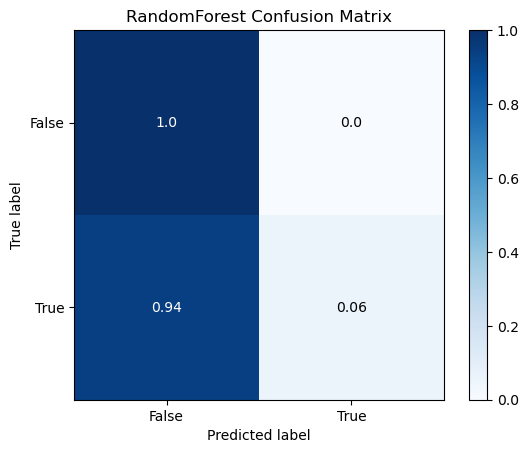

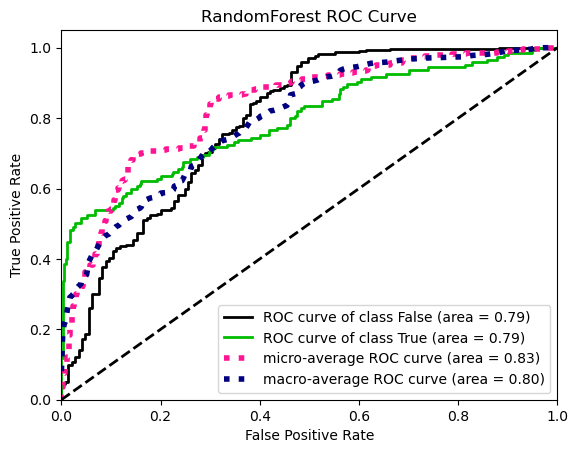

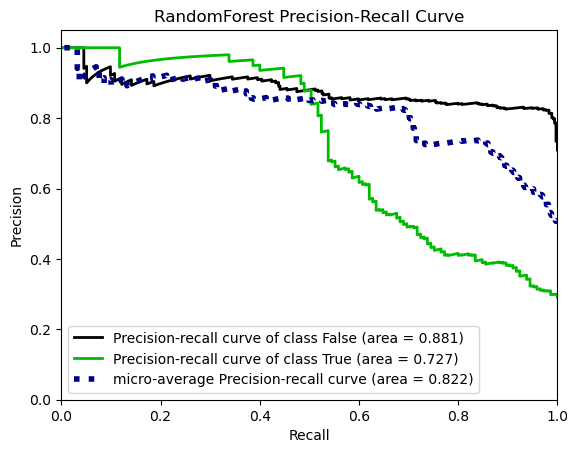

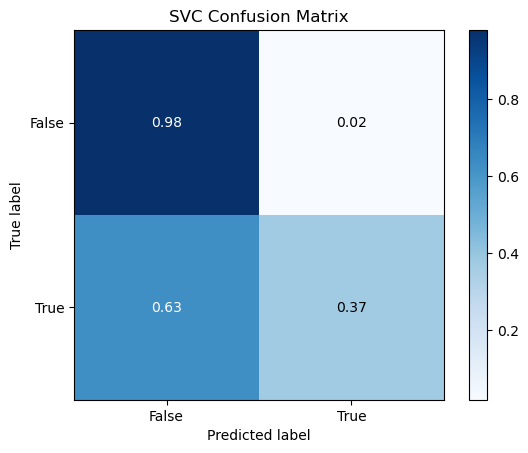

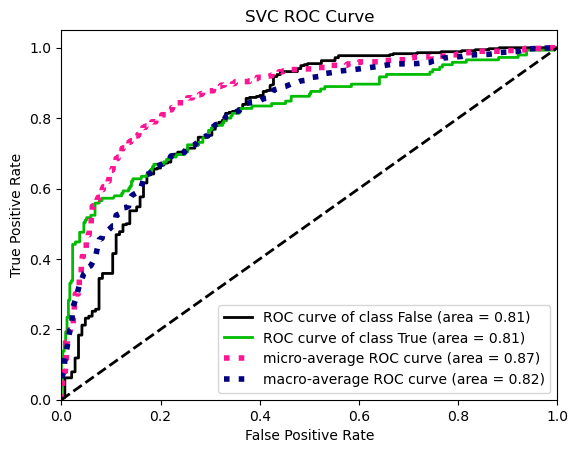

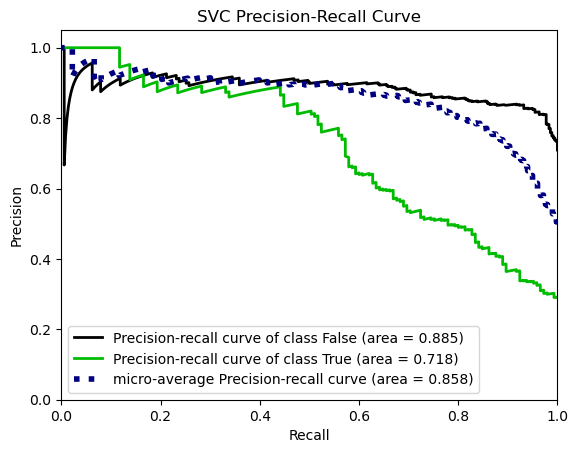

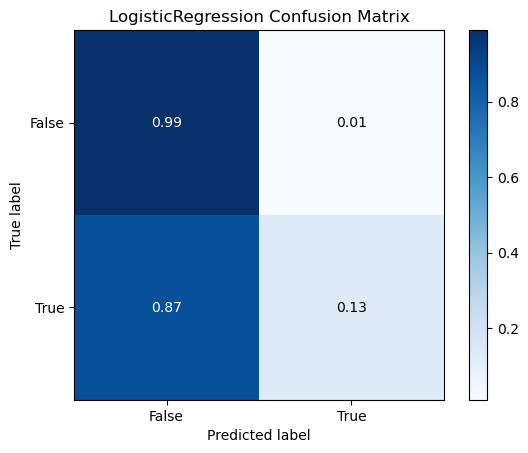

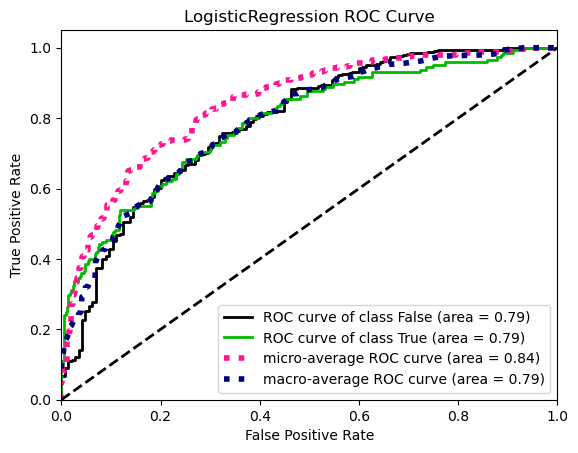

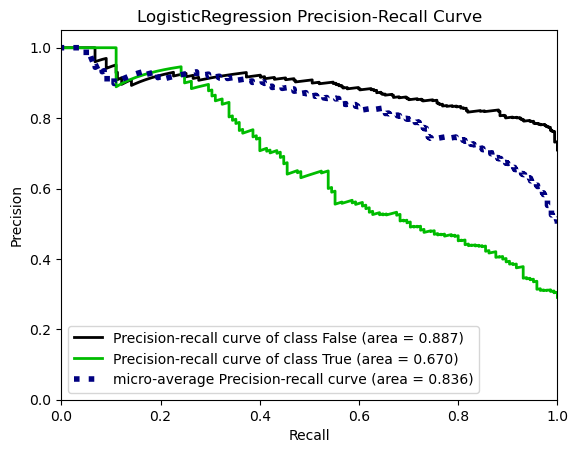

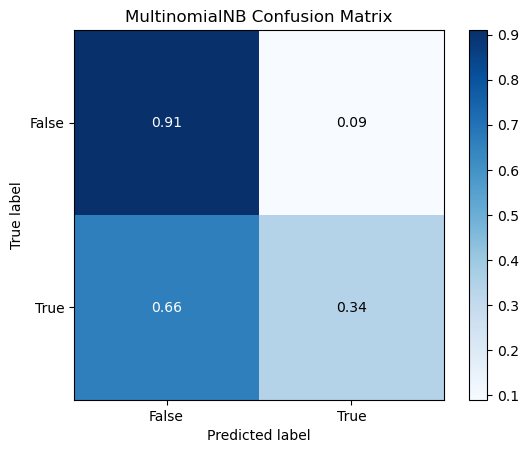

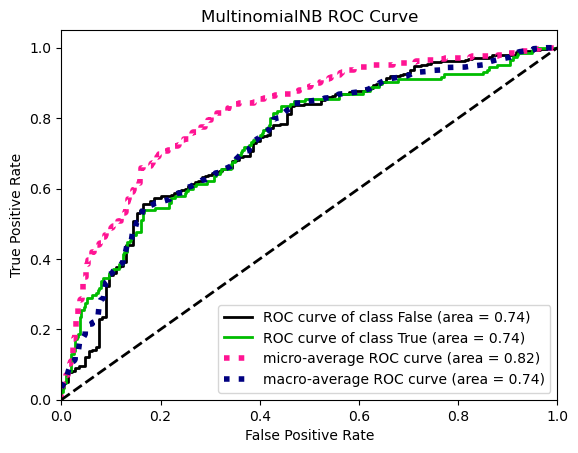

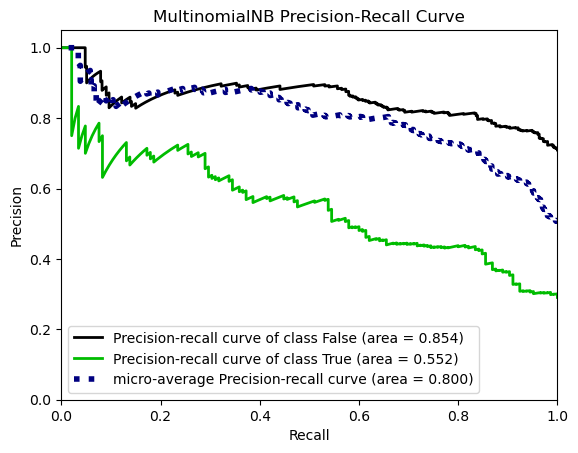

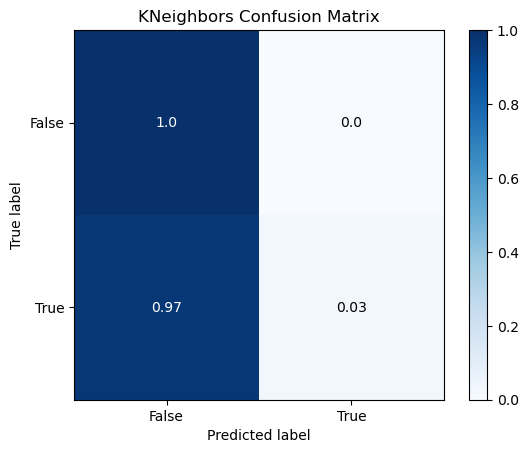

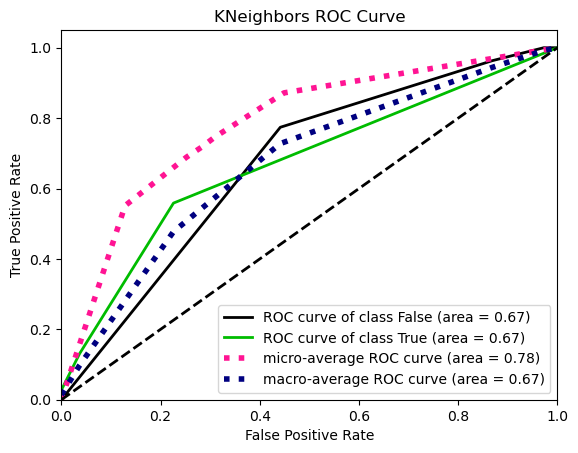

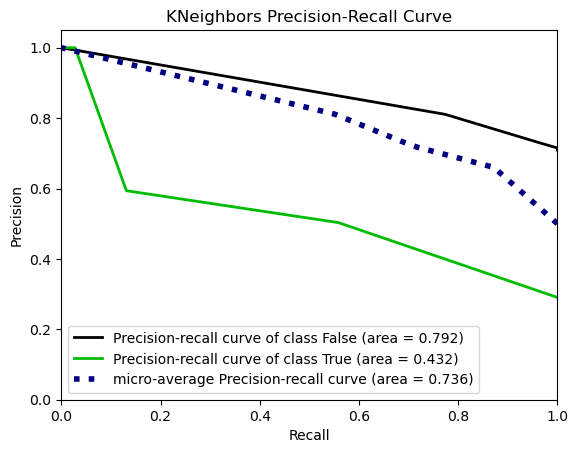

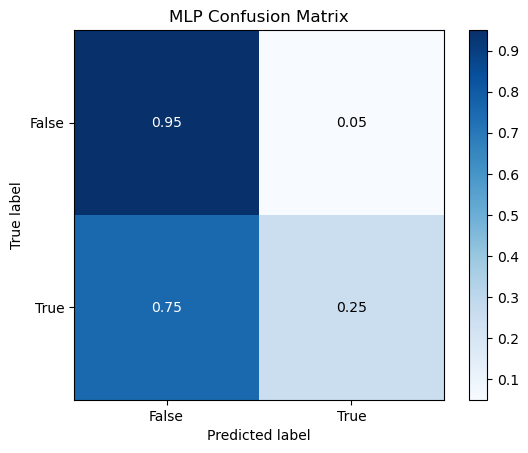

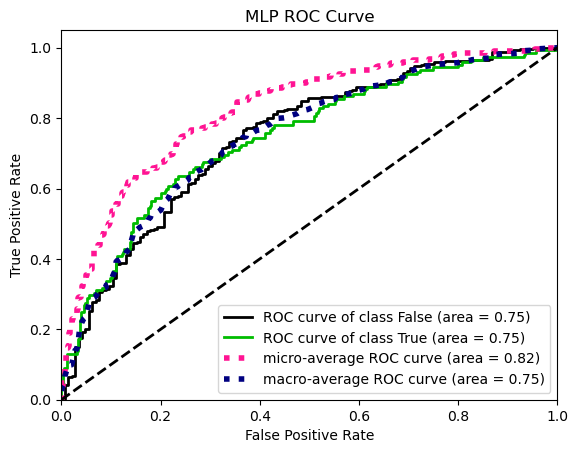

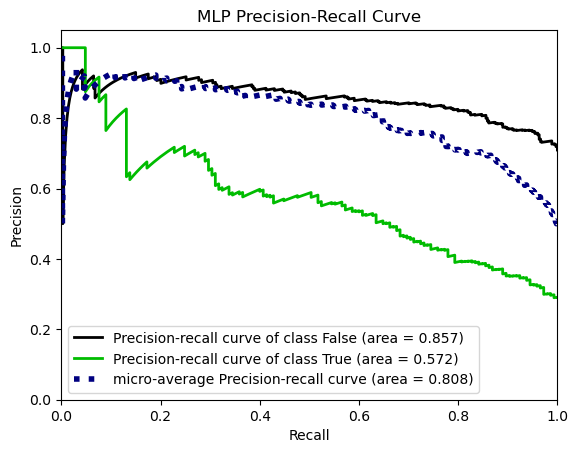

In [14]:
# Create an empty dataframe for model, F1 score, and per-class precision, and recall
df_metrics = pd.DataFrame(columns=[
    'Model', 
    'F1 Score', 
    'Accuracy', 
    'Positive Precision', 
    'Positive Recall', 
    'Negative Precision', 
    'Negative Recall',
    'AUC',
    'AUCPR'
])

# Loop over each classifier
for name, classifier in classifiers.items():
    print('-----------------------------')
    print(name)
    print('-----------------------------')

    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', MinMaxScaler((0, 1))), # Range from 0 - 1 since MultinomialNB doesn't like negative inputs
        ('model', classifier)
    ])

    # Fit the model using cross-validation and generate a confusion matrix
    scores = cross_validate(pipeline, X, y, cv=5, scoring=['f1', 'precision_macro', 'precision_micro', 'accuracy', 'roc_auc', 'average_precision'], return_train_score=False)
    y_pred = cross_val_predict(pipeline, X, y, cv=5)
    proba = cross_val_predict(pipeline, X, y, cv=5, method='predict_proba')

    # Calculate metrics
    f1 = scores['test_f1'].mean()
    accuracy = scores['test_accuracy'].mean()
    metrics = classification_report(y, y_pred, output_dict=True)
    pos_precision = metrics['True']['precision']
    neg_precision = metrics['False']['precision']
    pos_recall = metrics['True']['recall']
    neg_recall = metrics['False']['recall']
    print(f'F1: {f1}')
    print(f'Accuracy: {accuracy}')
    print(f'Positive Precision: {pos_precision}')
    print(f'Positive Recall: {pos_recall}')
    print(f'Negative Precision: {neg_precision}')
    print(f'Negative Recall: {neg_recall}')

    # Append a row to the dataframe    
    df_metrics = pd.concat([df_metrics, pd.DataFrame({
        'Model': 'SciKit-Learn ' + name,
        'F1 Score': f1,
        'Accuracy': accuracy,
        'Positive Precision': pos_precision,
        'Positive Recall': pos_recall,
        'Negative Precision': neg_precision,
        'Negative Recall': neg_recall,
        'AUC': scores['test_roc_auc'].mean(),
        'AUCPR': scores['test_average_precision'].mean()
    }, index=[0])])

    # Confusion matrix
    skplt.metrics.plot_confusion_matrix(y, y_pred, normalize=True, title=name + ' Confusion Matrix')

    # Display the ROC Curve
    skplt.metrics.plot_roc(y, proba, title=name + ' ROC Curve')
    skplt.metrics.plot_precision_recall(y, proba, title=name + ' Precision-Recall Curve')
    
df_metrics

In [15]:
df_metrics.to_csv('./data/sklearn_models.csv', index=False)

df_metrics

,Model,F1 Score,Accuracy,Positive Precision,Positive Recall,Negative Precision,Negative Recall,AUC,AUCPR
0,RandomForest,0.116559,0.727434,1.000000,0.062069,0.722449,1.000000,0.792562,0.728432
0,SVC,0.515148,0.803576,0.898305,0.365517,0.790909,0.983051,0.822409,0.744405
0,LogisticRegression,0.212625,0.743434,0.904762,0.131034,0.736402,0.994350,0.794522,0.694229
0,MultinomialNB,0.421659,0.743495,0.602410,0.344828,0.771635,0.906780,0.754179,0.611169
0,KNeighbors,0.052473,0.717414,1.000000,0.027586,0.715152,1.000000,0.678106,0.461357
0,MLP,0.337376,0.749495,0.692308,0.248276,0.756152,0.954802,0.764649,0.640975
